In [56]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

In [57]:
import zipfile

file_path = "/content/MNIST.zip"

# Распаковка архива
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    input_path = '/content/mnist_data'
    zip_ref.extractall(input_path)

In [58]:
import numpy as np
import struct
from array import array
from os.path import join


class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

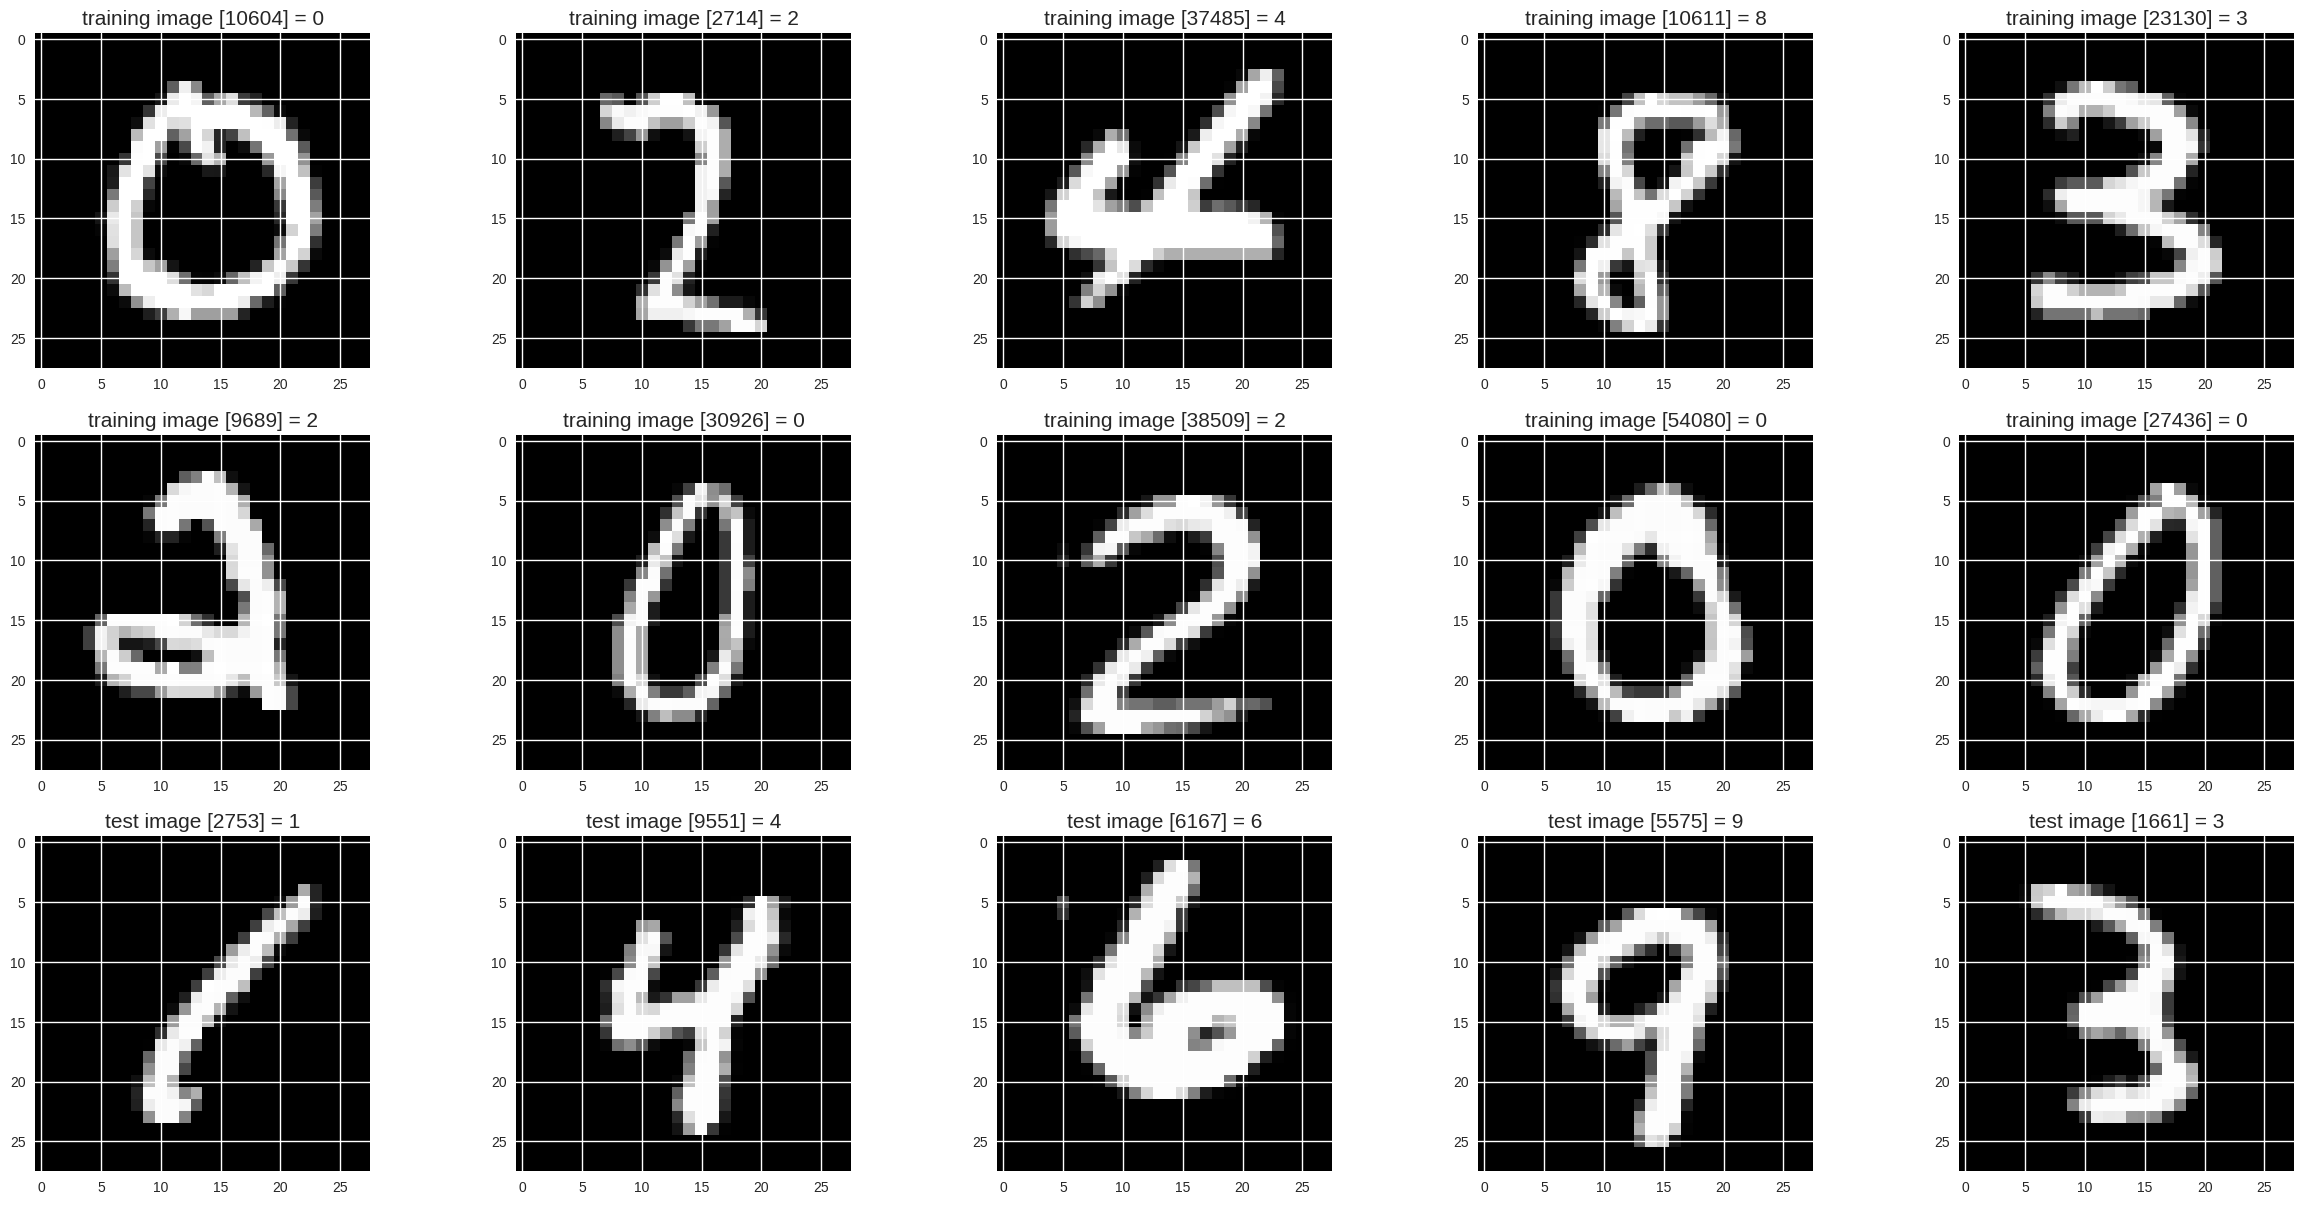

In [59]:
%matplotlib inline
import random
import matplotlib.pyplot as plt


training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))


show_images(images_2_show, titles_2_show)

In [60]:
from sklearn.preprocessing import LabelBinarizer

def preprocess_data(X_train, X_test, y_train, y_test):
    X_train = np.array([np.concatenate(arrays, axis=None) for arrays in X_train ])
    X_test = np.array([np.concatenate(arrays, axis=None) for arrays in X_test ])

    # Нормализация пикселей от 0 до 1
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Преобразуем метки в one-hot encoding
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)

In [61]:
X_train.shape

(60000, 784)

In [62]:
y_train[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [63]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.parameters = self.initialize_parameters(input_size, hidden_size, output_size)

    def initialize_parameters(self, input_size, hidden_size, output_size):
        # Инициализация весов маленькими случайными значениями
        W1 = np.random.randn(input_size, hidden_size) * 0.01
        b1 = np.zeros((1, hidden_size))
        W2 = np.random.randn(hidden_size, output_size) * 0.01
        b2 = np.zeros((1, output_size))
        return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward_propagation(self, X):
        W1, b1, W2, b2 = self.parameters['W1'], self.parameters['b1'], self.parameters['W2'], self.parameters['b2']

        Z1 = X.dot(W1) + b1
        A1 = self.relu(Z1)

        Z2 = A1.dot(W2) + b2
        A2 = self.softmax(Z2)

        cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2, cache

    def loss_function(self, A2, Y):
        m = Y.shape[0]
        loss = -np.sum(Y * np.log(A2 + 1e-8)) / m
        return loss

    def backward_propagation(self, X, Y, cache):
        m = X.shape[0]
        W1, W2 = self.parameters['W1'], self.parameters['W2']
        A1, A2, Z1 = cache['A1'], cache['A2'], cache['Z1']

        # Градиенты выходного слоя
        dZ2 = A2 - Y
        dW2 = (A1.T.dot(dZ2)) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Градиенты скрытого слоя
        dA1 = dZ2.dot(W2.T)
        dZ1 = dA1 * (Z1 > 0)  # производная ReLU
        dW1 = (X.T.dot(dZ1)) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        gradients = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return gradients

    def update_parameters(self, gradients, learning_rate):
        self.parameters['W1'] -= learning_rate * gradients['dW1']
        self.parameters['b1'] -= learning_rate * gradients['db1']
        self.parameters['W2'] -= learning_rate * gradients['dW2']
        self.parameters['b2'] -= learning_rate * gradients['db2']

    def predict(self, X):
        A2, _ = self.forward_propagation(X)
        return np.argmax(A2, axis=1)

    def accuracy(self, X, y):
        # Вычисление точности
        predictions = self.predict(X)
        return np.mean(predictions == np.argmax(y, axis=1))

In [64]:
def train_model(X_train, y_train, X_test, y_test,
                                 hidden_size=300, learning_rate=0.1,
                                 epochs=20, batch_size=64):
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    nn = NeuralNetwork(input_size, hidden_size, output_size)

    train_losses = []
    train_accuracies = []
    test_accuracies = []
    epoch_loss = 0.0
    num_batches = 0

    for epoch in range(epochs):
        start_time = time.time()

        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            A2, cache = nn.forward_propagation(X_batch)

            loss = nn.loss_function(A2, y_batch)
            epoch_loss += loss
            num_batches += 1

            gradients = nn.backward_propagation(X_batch, y_batch, cache)
            nn.update_parameters(gradients, learning_rate)

        # Средняя ошибка за эпоху
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        train_acc = nn.accuracy(X_train, y_train)
        test_acc = nn.accuracy(X_test, y_test)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        epoch_time = time.time() - start_time

        print(f"Epoch: [{epoch+1}/{epochs}],",
              f"Loss: {avg_loss:.4f},",
              f"Time: {epoch_time:.2f} sec")
        print(f"Accuracy (train): {train_acc:.4f},",
              f"Accuracy (test): {test_acc:.4f},")
        print("----------------------------------")

    return nn, train_losses, train_accuracies, test_accuracies


nn, train_losses, train_accuracies, test_accuracies = train_model(
    X_train, y_train, X_test, y_test
)

Epoch: [1/20], Loss: 0.5152, Time: 8.31 sec
Accuracy (train): 0.9209, Accuracy (test): 0.9257,
----------------------------------
Epoch: [2/20], Loss: 0.3757, Time: 7.34 sec
Accuracy (train): 0.9439, Accuracy (test): 0.9424,
----------------------------------
Epoch: [3/20], Loss: 0.3088, Time: 5.81 sec
Accuracy (train): 0.9594, Accuracy (test): 0.9561,
----------------------------------
Epoch: [4/20], Loss: 0.2661, Time: 7.94 sec
Accuracy (train): 0.9661, Accuracy (test): 0.9613,
----------------------------------
Epoch: [5/20], Loss: 0.2357, Time: 5.60 sec
Accuracy (train): 0.9729, Accuracy (test): 0.9659,
----------------------------------
Epoch: [6/20], Loss: 0.2123, Time: 7.56 sec
Accuracy (train): 0.9769, Accuracy (test): 0.9705,
----------------------------------
Epoch: [7/20], Loss: 0.1938, Time: 4.95 sec
Accuracy (train): 0.9789, Accuracy (test): 0.9706,
----------------------------------
Epoch: [8/20], Loss: 0.1786, Time: 7.57 sec
Accuracy (train): 0.9797, Accuracy (test): 0.9

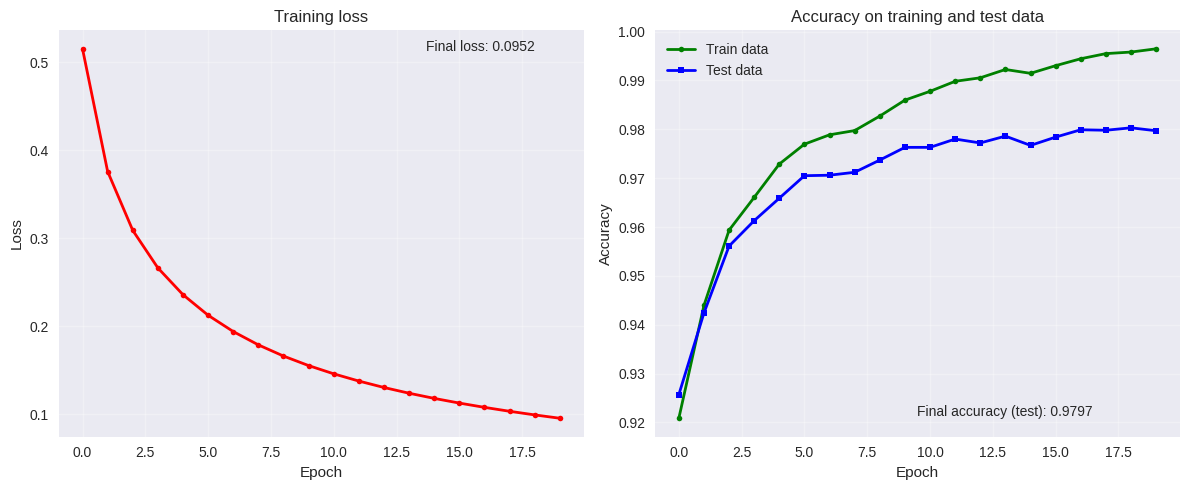

In [65]:
def plot_results(train_losses, train_accuracies, test_accuracies):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(train_losses, 'r-', linewidth=2, marker='o', markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training loss')
    ax1.grid(True, alpha=0.3)
    ax1.annotate(f'Final loss: {train_losses[-1]:.4f}',
                xy=(0.7, 0.95), xycoords='axes fraction')

    ax2.plot(train_accuracies, 'g-', linewidth=2, label='Train data', marker='o', markersize=4)
    ax2.plot(test_accuracies, 'b-', linewidth=2, label='Test data', marker='s', markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy on training and test data')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.annotate(f'Final accuracy (test): {test_accuracies[-1]:.4f}',
                xy=(0.5, 0.05), xycoords='axes fraction')


    plt.tight_layout()
    plt.show()

plot_results(train_losses, train_accuracies, test_accuracies)

In [66]:
print(f'Final accuracy (train): {train_accuracies[-1]:.4f}')
print(f'Final accuracy (test): {test_accuracies[-1]:.4f}')

Final accuracy (train): 0.9965
Final accuracy (test): 0.9797
